In [53]:
# Import all required libraries for API usage

import os
import numpy as np
import pandas as pd
import requests
import json
from sodapy import Socrata

In [298]:
# Import libraries required for visualization
%matplotlib inline
import hvplot.pandas
import plotly.express as px
from panel.interact import interact

## Retrieving API Data

In [55]:
# Identifying information for NYC OPENDATA for DOB Filings from 2000 to 2018

socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'ic3t-wcy2'
socrata_token = os.getenv('genS_token')



In [54]:
client = Socrata(socrata_domain, socrata_token)

#### Extracting information using the 'query' method

In [188]:
query = """
select Borough, Block, Lot, Pre__Filing_Date, Initial_Cost limit 1700421"""

results = client.get(socrata_dataset_identifier, query=query)
df = pd.DataFrame(results)
df.describe()

,Borough,Block,Lot,Pre__Filing_Date,Initial_Cost
count,1700421,1699669,1699665,1700421,1700421
unique,5,13794,1942,5889,90397
top,MANHATTAN,00016,00001,06/28/2019,$0.00
freq,753812,6642,209140,1717,460327


In [212]:
# placing 'results' into a dataframe called 'dob_filing'

dob_filing = pd.DataFrame(results)

In [213]:
# converting the 'Initial_Cost' field from an 'object' into a 'float'

dob_filing['Initial_Cost'] = dob_filing['Initial_Cost'].str.replace('$','')
dob_filing['Initial_Cost'] = dob_filing['Initial_Cost'].astype('float')
dob_filing.head()

,Borough,Block,Lot,Pre__Filing_Date,Initial_Cost
0,BROOKLYN,01224,00020,02/01/2008,10000.0
1,MANHATTAN,00498,00011,03/29/2016,1487158.0
2,BROOKLYN,01153,00023,05/09/2007,30000.0
3,MANHATTAN,01308,07501,04/05/2016,55000.0
4,BROOKLYN,00321,00009,05/15/2006,290000.0


In [214]:
dob_filing['Year'] = dob_filing.Pre__Filing_Date.str[-4:]
dob_filing['BLOCK'] = dob_filing.Block.str[-4:]
dob_filing.head()

,Borough,Block,Lot,Pre__Filing_Date,Initial_Cost,Year,BLOCK
0,BROOKLYN,01224,00020,02/01/2008,10000.0,2008,1224
1,MANHATTAN,00498,00011,03/29/2016,1487158.0,2016,0498
2,BROOKLYN,01153,00023,05/09/2007,30000.0,2007,1153
3,MANHATTAN,01308,07501,04/05/2016,55000.0,2016,1308
4,BROOKLYN,00321,00009,05/15/2006,290000.0,2006,0321


In [215]:
dob_filing.drop(columns=['Block','Lot','Pre__Filing_Date'], inplace=True)

In [236]:
dob_filing['BLOCK'] = dob_filing['BLOCK'].astype('float')
dob_filing.dropna(inplace=True)
dob_filing['BLOCK'] = dob_filing['BLOCK'].astype('int')
dob_filing.head()

,Borough,Initial_Cost,Year,BLOCK
0,BROOKLYN,10000.0,2008,1224
1,MANHATTAN,1487158.0,2016,498
2,BROOKLYN,30000.0,2007,1153
3,MANHATTAN,55000.0,2016,1308
4,BROOKLYN,290000.0,2006,321


In [222]:
dob_filing.dtypes

Borough          object
Initial_Cost    float64
Year             object
BLOCK             int32
dtype: object

## Import Block <---> Neighbhorhood CSV 

In [297]:
mttn_sales_path = 'Historic_Sales_Analysis/manhattan_neighborhood_block_zipcode.csv'
mttn_nbz_df = pd.read_csv(mttn_sales_path)
mttn_neighborhoods = set(mttn_nbz_df['NEIGHBORHOOD'])
print(mttn_nbz_df.describe())
mttn_nbz_df.head()

             BLOCK       ZIPCODE
count  4367.000000   4367.000000
mean   1178.060453  10026.239982
std     608.929211     28.805016
min       1.000000  10001.000000
25%     674.000000  10013.000000
50%    1230.000000  10022.000000
75%    1644.000000  10030.000000
max    2255.000000  10463.000000


,NEIGHBORHOOD,BLOCK,ZIPCODE
0,ALPHABET CITY,375,10009
1,ALPHABET CITY,372,10009
2,ALPHABET CITY,378,10009
3,ALPHABET CITY,391,10009
4,ALPHABET CITY,392,10009


### Remove Zipcode to reduce redundancy

In [281]:
mttn_nbz_df.drop(columns=['ZIPCODE'], inplace=True)
mttn_nbz_df['NEIGHBORHOOD'] = mttn_nbz_df['NEIGHBORHOOD'].str.strip()
mttn_nbz_df.drop_duplicates(inplace=True)
mttn_nbz_df.describe()
#mttn_nbz_df.head(20)

,BLOCK
count,1757.000000
mean,1129.083096
std,633.009453
min,1.000000
25%,584.000000
50%,1131.000000
75%,1636.000000
max,2255.000000


### Slice Manhattan Dataframe

In [283]:
manhattan_df = dob_filing[
    (dob_filing['Borough']=='MANHATTAN') &
    (dob_filing['Initial_Cost']>=50000) &
    (dob_filing['BLOCK']>100)
]

print(manhattan_df.describe())
manhattan_df.sample(10)

       Initial_Cost          BLOCK
count  2.437510e+05  243751.000000
mean   4.034850e+05    1103.790729
std    3.262041e+06     484.467813
min    5.000000e+04     101.000000
25%    7.500000e+04     808.000000
50%    1.261600e+05    1127.000000
75%    2.775000e+05    1367.000000
max    9.003000e+08    9999.000000


,Borough,Initial_Cost,Year,BLOCK
745244,MANHATTAN,1150000.0,2010,546
1429965,MANHATTAN,105000.0,2000,757
1586343,MANHATTAN,75000.0,2006,1261
824910,MANHATTAN,120000.0,2011,1933
1042720,MANHATTAN,50000.0,2014,2138
897009,MANHATTAN,200000.0,2012,1265
1496404,MANHATTAN,90000.0,2003,935
1305146,MANHATTAN,685000.0,2017,809
1322447,MANHATTAN,172250.0,2017,1501
1473656,MANHATTAN,55000.0,2002,1469


In [284]:
mttn_neigh = pd.merge(manhattan_df,mttn_nbz_df, on='BLOCK', how='left')
mttn_neigh.drop_duplicates()

print(mttn_neigh.describe())
mttn_neigh.head(50)


       Initial_Cost          BLOCK
count  2.463440e+05  246344.000000
mean   4.032800e+05    1101.267297
std    3.252874e+06     485.090499
min    5.000000e+04     101.000000
25%    7.500000e+04     806.000000
50%    1.260000e+05    1124.000000
75%    2.770000e+05    1365.000000
max    9.003000e+08    9999.000000


,Borough,Initial_Cost,Year,BLOCK,NEIGHBORHOOD
0,MANHATTAN,1487158.0,2016,498,SOHO
1,MANHATTAN,55000.0,2016,1308,MIDTOWN CBD
2,MANHATTAN,558000.0,2009,1023,MIDTOWN WEST
3,MANHATTAN,50400.0,2011,813,FASHION
4,MANHATTAN,443015.0,2016,1386,UPPER EAST SIDE (59-79)
5,MANHATTAN,155000.0,2011,813,FASHION
6,MANHATTAN,70000.0,2011,813,FASHION
7,MANHATTAN,144300.0,2011,813,FASHION
8,MANHATTAN,204750.0,2011,232,SOHO
9,MANHATTAN,355000.0,2012,1406,UPPER EAST SIDE (59-79)


In [265]:
manhattan_neighborhoods = set(mttn_neigh['NEIGHBORHOOD'])
len(manhattan_neighborhoods)

42

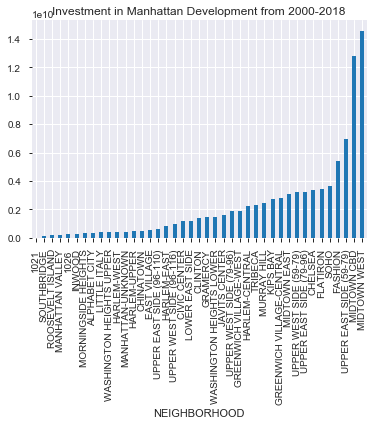

In [296]:
mttn_df_yearly = mttn_neigh.groupby(['NEIGHBORHOOD'])['Initial_Cost'].sum().sort_values()

total_investment_mttn = mttn_df_yearly.plot.bar(rot=90, title = 'Investment in Manhattan Development from 2000-2018')

In [319]:
# Define new dataframe that sums all the yearly development costs per neighborhood
mttn_yearly_dev = mttn_neigh.groupby(['NEIGHBORHOOD','Year']).sum().reset_index()
mttn_yearly_dev.head()

,NEIGHBORHOOD,Year,Initial_Cost,BLOCK
0,1021,2000,195000.0,481
1,1021,2001,70000.0,481
2,1021,2002,5100000.0,962
3,1021,2003,806000.0,1924
4,1021,2006,140000.0,962


## Development in Manhattan by Neighborhood (2000-2018)

In [321]:
def mttn_neigh_slice(Neighborhood):
    mttn_slice = mttn_yearly_dev[mttn_yearly_dev['NEIGHBORHOOD'].isin([Neighborhood])]
    return mttn_slice.hvplot.line(
        x='Year',
        y='Initial_Cost'
        ).opts(xlabel='Year', ylabel='Estimated Development Spending',yformatter="%.0f")
interact(mttn_neigh_slice, Neighborhood=manhattan_neighborhoods)

Column
    [0] Column
        [0] Select(name='Neighborhood', options=[nan, 'UPPER WEST SIDE (79...], value=nan)
    [1] Row
        [0] HoloViews(Curve, name='interactive03297')